# Resampling Techniques

Resampling techniques have not been as commonly discussed or used in scientific analysis because of the computational constraints. However, computer time is pretty cheap now, so, these techniques can be found more regularly in the peer reviewed literature. 

These are useful techniques to be aware of as they can be useful when we have small sample sizes but, the underlying distribution is *not* normal. 

These types of techniques are best understood by looking at examples. 

## Bootstrapping

Let's start with an example of a resampling technique called **"bootstrap"** resampling. Bootstrap resampling or *bootstrapping* is one of the most common resampling techniques and involves random resampling with replacement (this means that you can resample the same data more than once). There are many different ways to use bootstrapping, here are a couple:

- *Bootstrapping for hypothesis testing* involves constructing a large number of resamples of the original dataset. These resamples should be of equal size to a specific sample of interest (which is itself drawn from the original dataset) and be drawn by random sampling with replacement from the original dataset. In this way, you can construct a sampling distribution and you never need to assume anything about the underlying distribution of the data as it is already built-in to the original dataset. This approach can be used for small sample sizes and is often done when you have a long observational climatology or climate model control integration to draw samples from.

- *Bootstrapping for confidence intervals* involves resampling your specific sample to create a sampling distribution based on your specific sample data. From this sampling distribution you can compute confidence intervals. 

Let's look at an example. For this example, we are going to examine a large-scale mode of atmospheric variability, the North Atlantic Oscillation (NAO). You can download your own copy of the NAO data file [here](https://github.com/kls2177/ccia_files/blob/master/nao_timeseries.mat?raw=true).

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=16) #set default font size and weight for plots
import scipy.stats as st
import scipy.io as sio
import time
from IPython import display

In [2]:
# Load data (we are loading a monthly time series of the North Atlantic Oscillation)
NAO = sio.loadmat('nao_timeseries.mat')

X = NAO['NAO'][:,0] # grab January data only
TIME_NAO = NAO['TIME_NAO'][:,0]

A good habit to get into is the quickly check the size of your dataset before you begin. 

In [3]:
print(X.shape)
print(TIME_NAO)

(63,)
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012]


So, we have 63 January's from 1950-2012. Let's plot the data to see what it looks like.

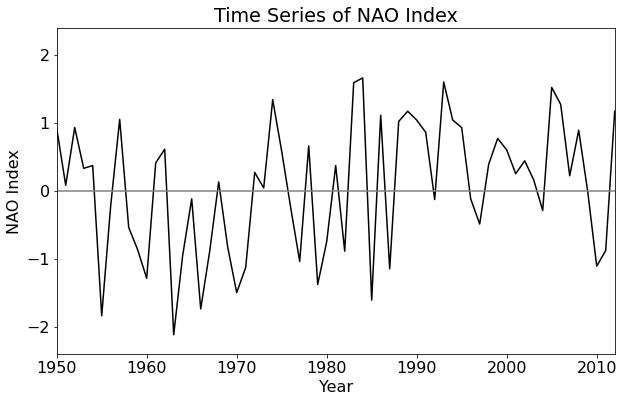

In [4]:
# Plot time series
plt.figure(figsize=(10,6))
plt.plot(TIME_NAO,X,color = 'black', linewidth = 1.5)
plt.xlabel('Year')
plt.ylabel('NAO Index')
plt.title('Time Series of NAO Index')
plt.ylim(-2.4,2.4)
plt.xlim(min(TIME_NAO), max(TIME_NAO))
plt.axhline(0,color='gray')

If you squint at the data, you might see that the NAO tends to be mostly negative from 1954-1971 and mostly positive from 1989-2006. Let's compute the sample means for these two 18-year segments of the time series.

In [5]:
# mean 1954-1971
NAO1 = np.mean(X[4:22])

# mean 1989-2006
NAO2 = np.mean(X[39:57])

print(np.round(NAO1,3),np.round(NAO2,3))

NAO_diff = NAO2 - NAO1

print("The difference is", np.round(NAO_diff,3))

-0.637 0.612
The difference is 1.249


We could use a $t$-test to test whether there is a significant difference in the NAO index between these two time periods, but instead let's use bootstrapping.

So, we are going to randomly resample our original NAO time series and grab a pair of 18-year samples (with replacement) and compute the difference.

In [6]:
N=18
NAO_diff_bootstrap=[]
for i in np.arange(0,100000):
    NAO1_tmp = np.mean(np.random.choice(X,N))
    NAO2_tmp = np.mean(np.random.choice(X,N))
    NAO_diff_bootstrap.append(NAO2_tmp - NAO1_tmp)

Now, we can plot the distribution of differences to examine the probability of obtaining our observed difference. First, we generate the histogram...

In [7]:
# create bins 
bins = np.linspace(np.min(NAO_diff_bootstrap),np.max(NAO_diff_bootstrap),np.int((np.max(NAO_diff_bootstrap)-np.min(NAO_diff_bootstrap))/0.01))

# calculate the histogram
histNAO_diff,bins = np.histogram(NAO_diff_bootstrap,bins)

# convert counts to frequency
freqNAO_diff = histNAO_diff/len(NAO_diff_bootstrap)

... next, we plot it along with our observed NAO difference.

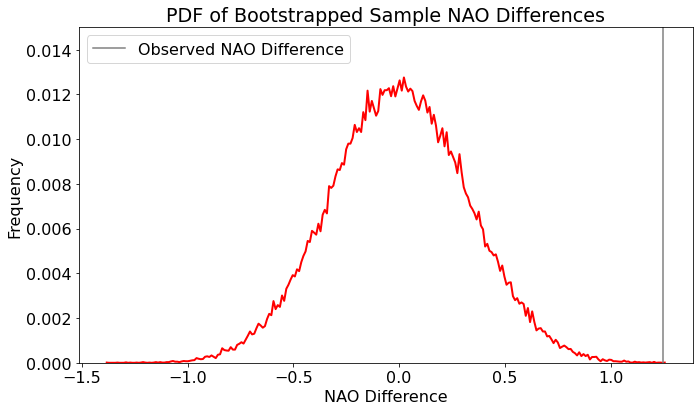

In [8]:
plt.figure(figsize=(10,6))

# xbins for plotting
xbins = np.linspace(np.min(NAO_diff_bootstrap),np.max(NAO_diff_bootstrap),len(histNAO_diff))

# plot the distribution
plt.plot(xbins,freqNAO_diff,'r',linewidth=2)
plt.axvline(np.mean(NAO_diff),color='gray',label="Observed NAO Difference")
plt.ylabel('Frequency')
plt.xlabel('NAO Difference')
plt.legend(loc='upper left')
plt.ylim(0,0.015)
plt.title('PDF of Bootstrapped Sample NAO Differences')
plt.tight_layout()

Now, we can clearly visualize that our observed difference is in the very tail of our bootstrapped sampling distribution, indicating that the probability of obtaining such a large difference is very low. How low? Let's see.

In [9]:
# use st.percentileofscore() to find the probability of obtaining a value of NAO_diff or higher
1-st.percentileofscore(NAO_diff_bootstrap,np.mean(NAO_diff))/100.0

1.0000000000065512e-05

Really low! This means that the difference between these two 18-year segments is quite anomalous. Note that here we are assuming that each year in our 18-year segments is independent, but in reality this is often not the case. We will discuss how to deal with this issue later in the course.

## Jackknifing

**Jackknife** resampling is very similar to bootstrapping except that you systematically remove one value from your sample, and calculate the statistic, then put the value back into the sample and remove the next value, calculate the statistics...and on and on. 

Let's take a look at an example of this using the NAO index data from above.

Suppose we are interested in examining the trend in this data (we will talk about trends and regression analysis in more detail next week).

We can use a simple linear fit to estimate the trend.

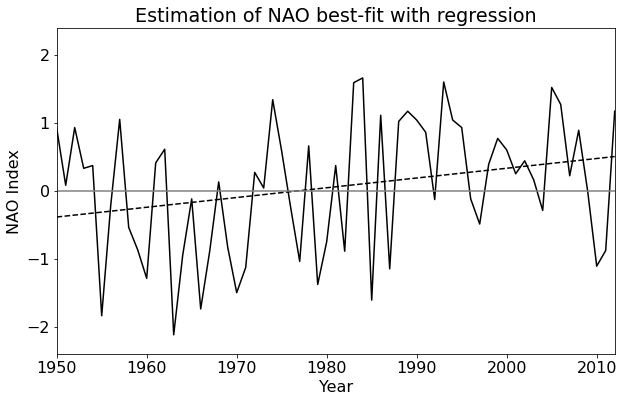

In [10]:
# Compute Linear fit
trend = np.polyfit(TIME_NAO,X,1) #trend has two components: the slope and the intercept 

# Plot data with linear fit
plt.figure(figsize=(10,6))
plt.plot(TIME_NAO,X,color = 'black', linewidth = 1.5)
plt.plot(TIME_NAO,TIME_NAO*trend[0]+trend[1],'--',color = 'black', linewidth = 1.5)
plt.xlabel('Year')
plt.ylabel('NAO Index')
plt.title('Estimation of NAO best-fit with regression')
plt.ylim(-2.4,2.4);
plt.xlim(min(TIME_NAO), max(TIME_NAO));
plt.axhline(0,color='gray')

**How do we determine the 95% confidence levels on this trend line?**

Next week, we will talk about how to do this using $z$- or $t$-statistics, but here we will use the jackknife resampling method to get at an estimate.

Following the jackknife method, we will remove one data point from our time series at a time, recalculate the linear fit and repeat. We will get a distribution of possible trends from which we can find the 95\% confidence bounds.

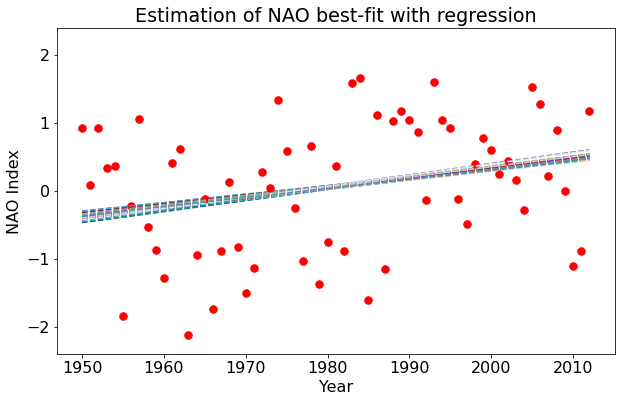

In [11]:
# Initialize an array of size (63,2). The dimension of size 63 reflects the number of iterations
# and the dimension of size 2 reflects that we will store our slopes and intercepts.
M = np.zeros((len(X),2))

# Initialize plot
plt.figure(figsize=(10,6))
plt.xlabel('Year');
plt.ylabel('NAO Index')
plt.title('Estimation of NAO best-fit with regression')

# Loop over data points
for j, val in enumerate(X):
    
    # Remove one data point
    Xj = np.delete(X,j)
    Tj = np.delete(TIME_NAO,j)
    
    # Calculate the linear fit using np.polyfit()
    trendj = np.polyfit(Tj,Xj,1) 
    
    # Save the slope and the intercept in an array
    M[j,0] = trendj[0] #slope
    M[j,1] = trendj[1] #intercept
    
    # Plot data
    if j < len(X)-1:
        
        # Plot the data point we are removing
        plt.plot(TIME_NAO[j],val,'.',color = 'red', markersize = 15)
        
        # Plot the trend line after the data point is removed
        plt.plot(Tj,Tj*trendj[0] + trendj[1],'--', color = np.random.random_sample(size = 3))
        plt.ylim(-2.4,2.4);
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.05)
    else:
        plt.plot(TIME_NAO[j],val,'.',color = 'red', markersize = 15)
        plt.plot(Tj,Tj*trendj[0] + trendj[1],'--', color = np.random.random_sample(size = 3))
        display.clear_output(wait=True)

As you can see we get a slightly different slope and y-intercept each time we remove a data point.

We can now use stats.scoreofpercentile() to find the confidence bounds on the slope and y-intercept.

In [12]:
slopes = np.squeeze(M[:,0])
yints = np.squeeze(M[:,1])

In [13]:
CI_upper_slope = st.scoreatpercentile(slopes,97.5)
CI_lower_slope = st.scoreatpercentile(slopes,2.5)
print("CI's for slope:",CI_upper_slope, CI_lower_slope)

CI_upper_yint = st.scoreatpercentile(yints,97.5)
CI_lower_yint = st.scoreatpercentile(yints,2.5)
print("CI's for y-intercept:",CI_upper_yint, CI_lower_yint)

CI's for slope: 0.01643790387102832 0.012843908503342084
CI's for y-intercept: -25.38189061734485 -32.506970065596256


To get a sense of the entire ditribution of slopes and y-intercepts, let's plot the histograms and add our confidence intervals as vertical lines.

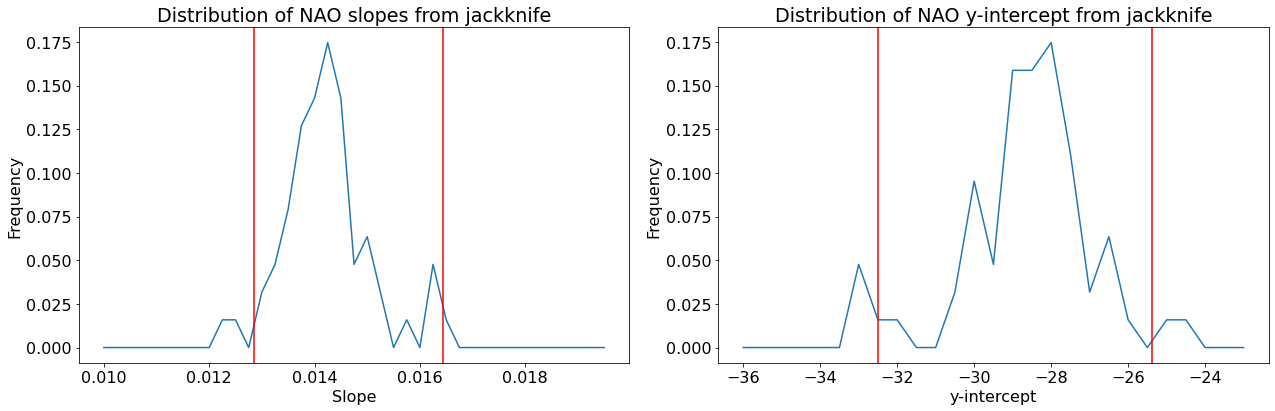

In [14]:
# Plot histogram of slopes
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
xint = np.arange(.01,.02,.00025)
b, bin_edges = np.histogram(slopes,xint)
plt.plot(bin_edges[:-1],b/M.shape[0])

# Plot 95% confidence intervals on slope
plt.axvline(CI_upper_slope,color='r')
plt.axvline(CI_lower_slope,color='r')

plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Distribution of NAO slopes from jackknife')

# Plot histogram of intercepts
plt.subplot(1,2,2)
xint = np.arange(-36.,-22.,.5)
y, bin_edges = np.histogram(yints,xint)
plt.plot(bin_edges[:-1],y/M.shape[0])

# Plot 95% confidence intervals on slope
plt.axvline(CI_upper_yint,color='r')
plt.axvline(CI_lower_yint,color='r')

plt.xlabel('y-intercept')
plt.ylabel('Frequency')
plt.title('Distribution of NAO y-intercept from jackknife')
plt.tight_layout()